# Imports
***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from pylab import rcParams

%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()
np.random.seed(8)

import plotly.express as px

# Loading and visualizing data
***

In [14]:
header_list = ["spec_name", "impl_name", "set_size", "edge_prob", "policy_size", "spec_len", "rego_lines_of_code", "error_rate", "edge_number", "comp_cum_time", "result"]
df = pd.read_csv("one-id.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list)

chunks = pd.read_csv("equivalence.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list, chunksize=50000)
slim_data = []
for chunk in chunks:
    chunk["comp_cum_time"] *= 1000
    slim_data.append(chunk)
df = pd.concat(slim_data)

# Seconds to Milliseconds
#df["comp_cum_time"] *= 1000

df

,spec_name,impl_name,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time,result
0,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.899,False
1,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.875,False
2,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,7.930,False
3,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,6.369,False
4,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.773,False
...,...,...,...,...,...,...,...,...,...,...,...
8995,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.767,False
8996,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.944,False
8997,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,6.717,False
8998,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.972,False


# Removing outliers and harmonizing sample size
***

In [15]:
# All values of predictors
set_sizes = sorted(df.set_size.unique())
policy_sizes = sorted(df.policy_size.unique())
error_rates = sorted(df.error_rate.unique())


# Removing 0.7 error rates values from data
#error_rates = error_rates[:-1]


print("Used values:")
print("Set sizes: {}".format(set_sizes))
print("Policy sizes: {}".format(policy_sizes))
print("Error rates: {}".format(error_rates))
print("")


# Making list of DFs by predictors
preds_df_list = []
labels = []
for set_size in set_sizes:
    for policy_size in policy_sizes:
        for error_rate in error_rates:
            print("DF parameters: {} {} {}".format(set_size, policy_size, error_rate))
            labels.append("{} {} {}".format(set_size, policy_size, error_rate))
            preds_df_list.append(df[(df.set_size == set_size) & (df.policy_size == policy_size) & (df.error_rate == error_rate)])
print("\n")


# Print DF shapes
print("Unmodified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")


# Removing outliers in DFs
#new_preds_df_list = []
#for pred_df in preds_df_list: # Remove all values with Z-score > 3
#    new_preds_df_list.append( pred_df[np.abs(pred_df.comp_cum_time-pred_df.comp_cum_time.mean()) <= (3*pred_df.comp_cum_time.std())] )
#preds_df_list = new_preds_df_list


# Print DF shapes to check sample sizes, put them in list
preds_df_list_sample_sizes = []
print("No outliers DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
    preds_df_list_sample_sizes.append(pred_df.shape[0])
print("\n")

minimum_sample_size = min(preds_df_list_sample_sizes)
print("Minimum common sample size: {}".format(minimum_sample_size))

# Make sample sizes equal
new_preds_df_list = []
for pred_df in preds_df_list:
    new_preds_df_list.append(pred_df.head(minimum_sample_size))
preds_df_list = new_preds_df_list


# Check new DF shapes
print("Modified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")

Used values:
Set sizes: [100]
Policy sizes: [2]
Error rates: [0.4]

DF parameters: 100 2 0.4


Unmodified DF shapes
(9000, 11)


No outliers DF shapes
(9000, 11)


Minimum common sample size: 9000
Modified DF shapes
(9000, 11)




# Merge all data back together
***

In [16]:
merged_df = pd.DataFrame()
for pred_df in preds_df_list:
    merged_df = merged_df.append(pred_df)

merged_df

,spec_name,impl_name,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time,result
0,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.899,False
1,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.875,False
2,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,7.930,False
3,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,6.369,False
4,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.773,False
...,...,...,...,...,...,...,...,...,...,...,...
8995,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.767,False
8996,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.944,False
8997,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,6.717,False
8998,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.972,False


# Describe DF
***

In [17]:
merged_df.describe()

,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time
count,9000.0,9000.0,9000.0,9000.0,9000.0,9.000000e+03,9000.0,9000.000000
mean,100.0,1.0,2.0,250.0,23843.0,4.000000e-01,649.0,6.190419
std,0.0,0.0,0.0,0.0,0.0,5.551424e-17,0.0,0.653130
min,100.0,1.0,2.0,250.0,23843.0,4.000000e-01,649.0,5.698000
25%,100.0,1.0,2.0,250.0,23843.0,4.000000e-01,649.0,5.912000
50%,100.0,1.0,2.0,250.0,23843.0,4.000000e-01,649.0,6.010000
75%,100.0,1.0,2.0,250.0,23843.0,4.000000e-01,649.0,6.494000
max,100.0,1.0,2.0,250.0,23843.0,4.000000e-01,649.0,39.139000


In [18]:
print("Shape: {}\n".format(merged_df.shape))

Shape: (9000, 11)



In [19]:
print("Types")
print(merged_df.dtypes)
print("")

Types
spec_name              object
impl_name              object
set_size                int64
edge_prob             float64
policy_size             int64
spec_len                int64
rego_lines_of_code      int64
error_rate            float64
edge_number             int64
comp_cum_time         float64
result                   bool
dtype: object



In [20]:
print("Info")
merged_df.info()

Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 0 to 8999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   spec_name           9000 non-null   object 
 1   impl_name           9000 non-null   object 
 2   set_size            9000 non-null   int64  
 3   edge_prob           9000 non-null   float64
 4   policy_size         9000 non-null   int64  
 5   spec_len            9000 non-null   int64  
 6   rego_lines_of_code  9000 non-null   int64  
 7   error_rate          9000 non-null   float64
 8   edge_number         9000 non-null   int64  
 9   comp_cum_time       9000 non-null   float64
 10  result              9000 non-null   bool   
dtypes: bool(1), float64(3), int64(5), object(2)
memory usage: 782.2+ KB


# Plotting distributions
***

In [21]:
# Plotting function
def plot_distribution(inp):
    plt.figure()
    ax = sns.distplot(inp)
    plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=5)
    _, max_ = plt.ylim()
    plt.text(
        inp.mean() + inp.mean() / 10,
        max_ - max_ / 10,
        "Mean: {:.2f}".format(inp.mean()),
    )
    return plt.figure

In [22]:
# Color list for plots
colors = ["blue", "green", "yellow", "orange", "red", "pink", "purple", "grey", "black"]

In [23]:
# Plotting comp_cum_time count
fig = px.histogram(merged_df, x="comp_cum_time", marginal="violin") # or violin, rug
fig.show()

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

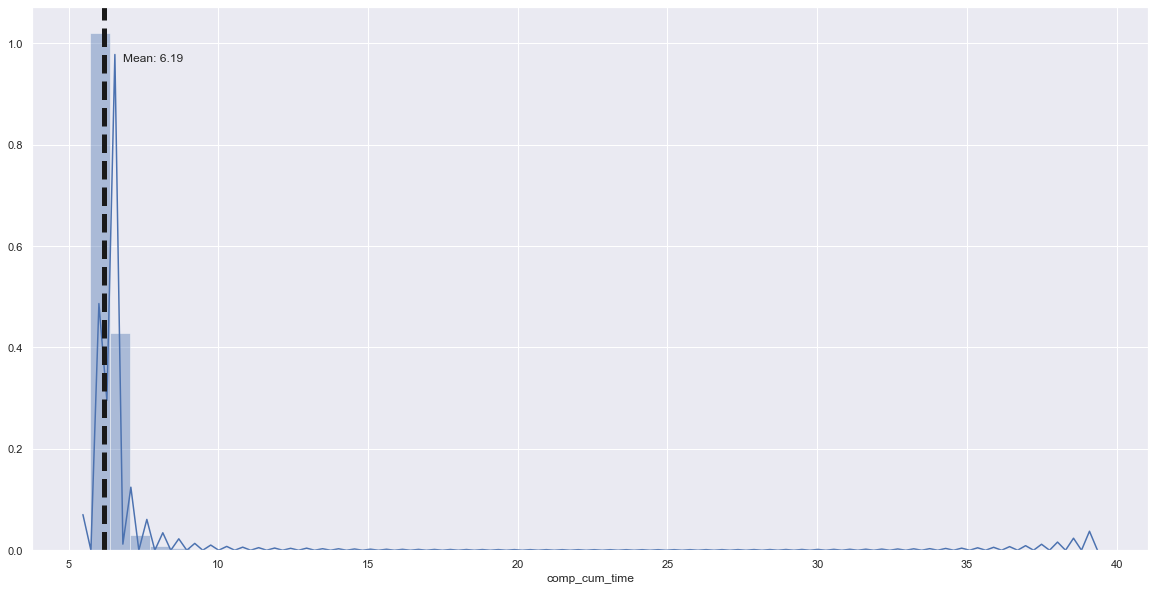

In [24]:
plot_distribution(merged_df["comp_cum_time"])

In [26]:
# List of DFs with different set sizes
set_sizes_df_list = []
for set_size in set_sizes:
    set_sizes_df_list.append(merged_df[(merged_df.set_size == set_size)])

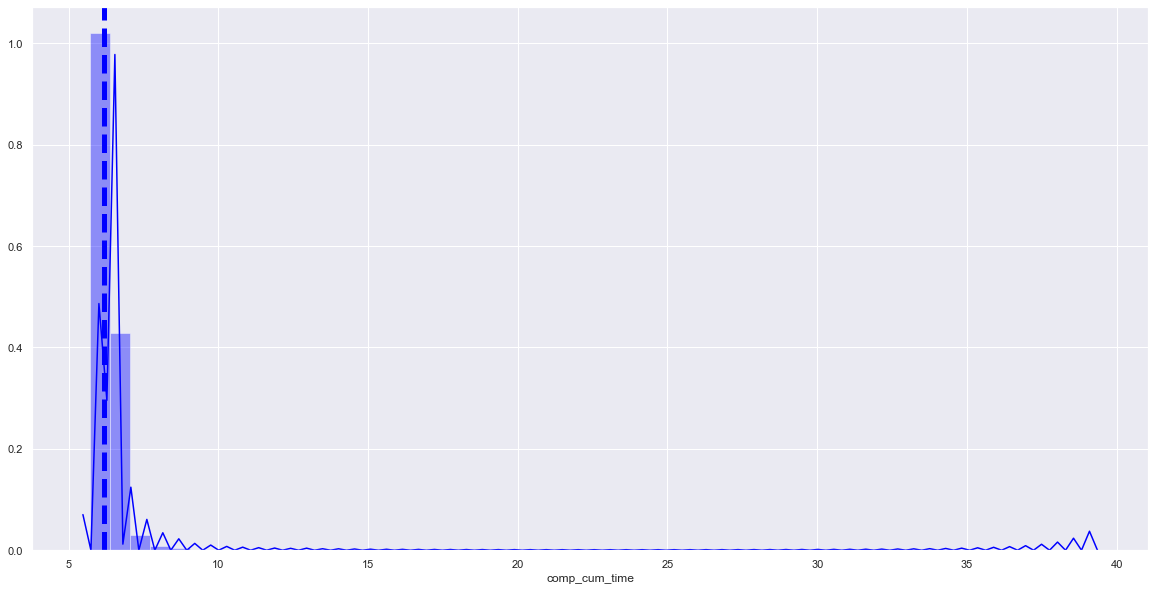

In [27]:
# Distplot with means comparing all set sizes
plt.figure()
for index, set_size_df in enumerate(set_sizes_df_list):
    ax = sns.distplot(set_size_df["comp_cum_time"], color=colors[index])
    plt.axvline(np.mean(set_size_df["comp_cum_time"]), color=colors[index], linestyle='dashed', linewidth=5)

In [28]:
# List of DFs with different policy sizes
policy_sizes_df_list = []
for policy_size in policy_sizes:
    policy_sizes_df_list.append(merged_df[(merged_df.policy_size == policy_size)])

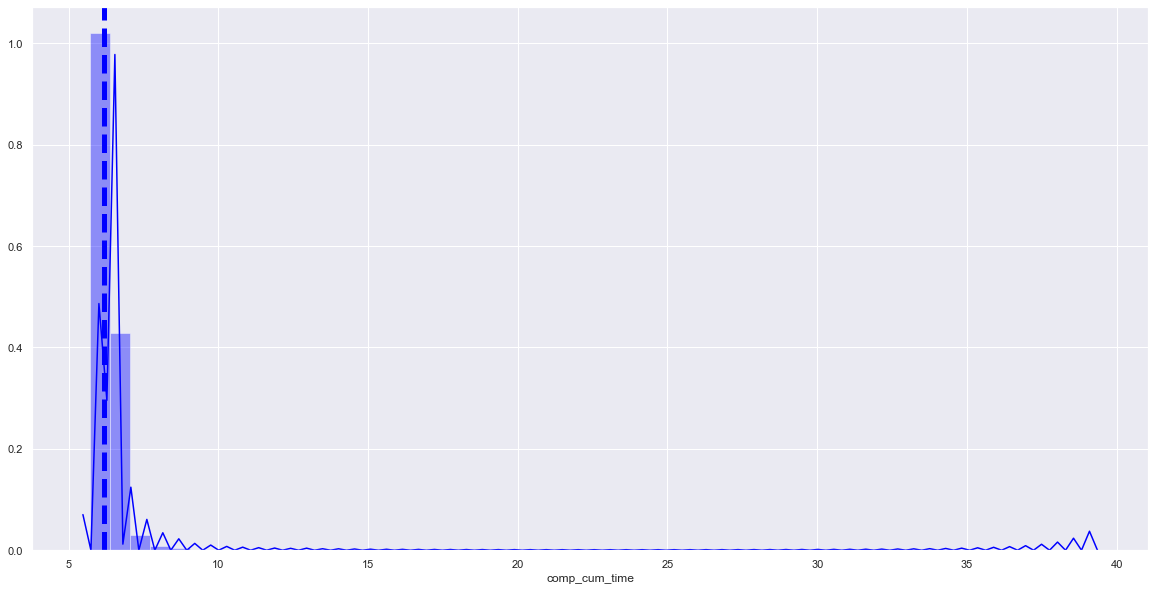

In [29]:
# Distplot with means comparing all set sizes
plt.figure()
for index, policy_size_df in enumerate(policy_sizes_df_list):
    ax = sns.distplot(policy_size_df["comp_cum_time"], color=colors[index])
    plt.axvline(np.mean(policy_size_df["comp_cum_time"]), color=colors[index], linestyle='dashed', linewidth=5)

In [30]:
# List of DFs with different error rates
error_rates_df_list = []
for error_rate in error_rates:
    error_rates_df_list.append(merged_df[(merged_df.error_rate == error_rate)])

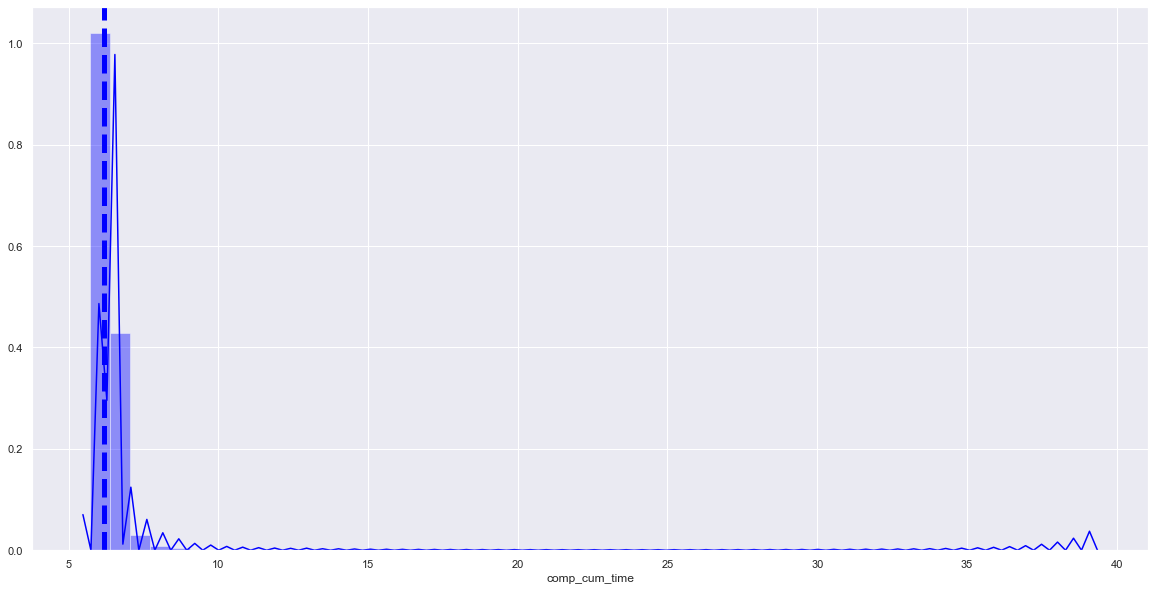

In [31]:
# Distplot with means comparing all set sizes
plt.figure()
for index, error_rate_df in enumerate(error_rates_df_list):
    ax = sns.distplot(error_rate_df["comp_cum_time"], color=colors[index])
    plt.axvline(np.mean(error_rate_df["comp_cum_time"]), color=colors[index], linestyle='dashed', linewidth=5)

# Boxplots
***

In [32]:
# Set size data in one DF
set_size_labels = ["set_size_10", "set_size_20", "set_size_30", "set_size_50", "set_size_100"]

df_set_sizes = pd.DataFrame()
for index, set_size_df in enumerate(set_sizes_df_list):
    df_set_sizes[set_size_labels[index]] = set_size_df.reset_index(drop=True)["comp_cum_time"]

df_set_sizes

,set_size_10
0,5.899
1,5.875
2,7.930
3,6.369
4,5.773
...,...
8995,5.767
8996,5.944
8997,6.717
8998,5.972


Text(0, 0.5, 'Algo duration (ms)')

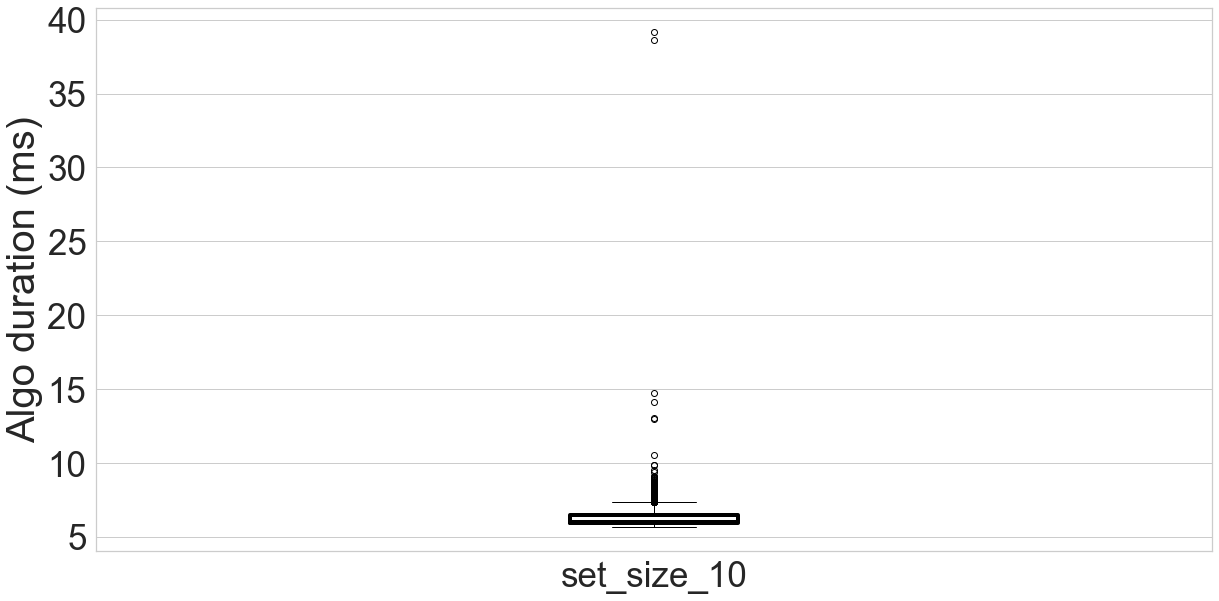

In [33]:
# Boxplot of equivalence time by set size
plt.figure()
sns.set_style("whitegrid")
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

ax = df_set_sizes.boxplot(color="black", boxprops=boxprops, medianprops=medianprops)
ax.grid(axis='y')

plt.grid(b=None)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.ylabel("Algo duration (ms)", fontsize=40)

In [34]:
# Policy size data in one DF
policy_size_labels = ["policy_size_1", "policy_size_2"]

df_policy_sizes = pd.DataFrame()
for index, policy_size_df in enumerate(policy_sizes_df_list):
    df_policy_sizes[policy_size_labels[index]] = policy_size_df.reset_index(drop=True)["comp_cum_time"]

df_policy_sizes

,policy_size_1
0,5.899
1,5.875
2,7.930
3,6.369
4,5.773
...,...
8995,5.767
8996,5.944
8997,6.717
8998,5.972


Text(0, 0.5, 'Algo duration (ms)')

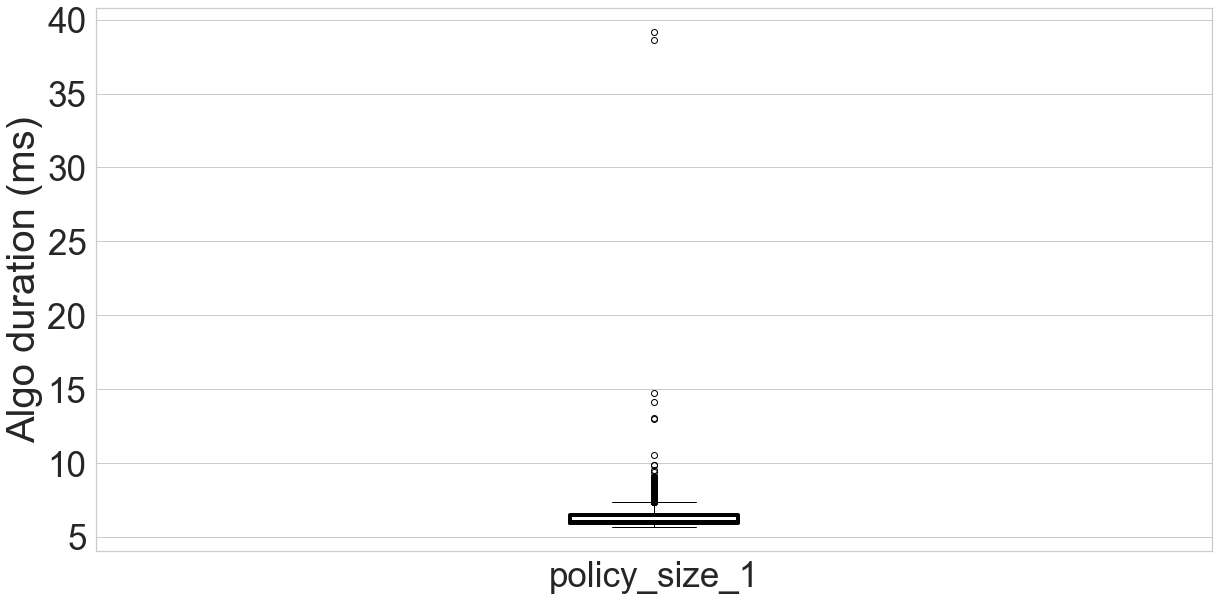

In [35]:
# Boxplot of equivalence time by set size
plt.figure()
sns.set_style("whitegrid")
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

ax = df_policy_sizes.boxplot(color="black", boxprops=boxprops, medianprops=medianprops)
ax.grid(axis='y')

plt.grid(b=None)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.ylabel("Algo duration (ms)", fontsize=40)

In [36]:
# Error rate data in one DF
error_rate_labels = ["error_rate_0_0", "error_rate_0_2", "error_rate_0_4", "error_rate_0_7"]

df_error_rates = pd.DataFrame()
for index, error_rate_df in enumerate(error_rates_df_list):
    df_error_rates[error_rate_labels[index]] = error_rate_df.reset_index(drop=True)["comp_cum_time"]

df_error_rates

,error_rate_0_0
0,5.899
1,5.875
2,7.930
3,6.369
4,5.773
...,...
8995,5.767
8996,5.944
8997,6.717
8998,5.972


Text(0, 0.5, 'Algo duration (ms)')

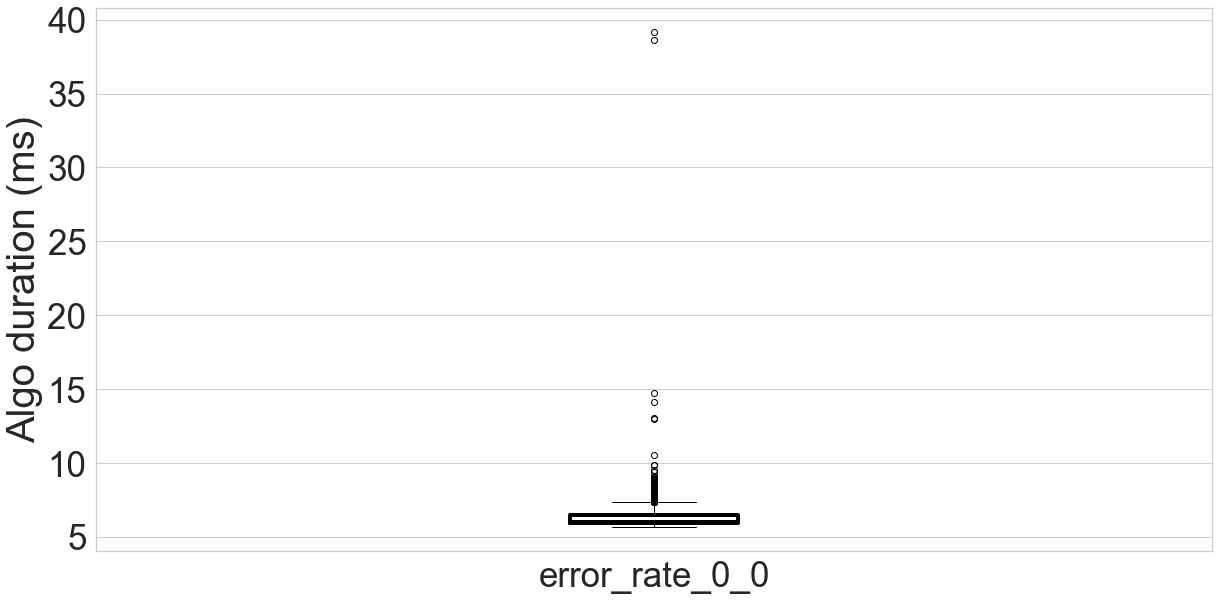

In [37]:
# Boxplot of equivalence time by set size
plt.figure()
sns.set_style("whitegrid")
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

ax = df_error_rates.boxplot(color="black", boxprops=boxprops, medianprops=medianprops)
ax.grid(axis='y')

plt.grid(b=None)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.ylabel("Algo duration (ms)", fontsize=40)

# Grouping
***

In [38]:
gdf = merged_df.groupby(['set_size','policy_size', 'error_rate']).sum()
gdf

,,,edge_prob,spec_len,rego_lines_of_code,edge_number,comp_cum_time,result
set_size,policy_size,error_rate,,,,,,
100,2,0.4,9000.0,2250000,214587000,5841000,55713.772,False
